In [1]:
# general useful imports
import pandas as pd
import numpy as np

# imports for splitting and scaling the data 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE


# imports for classifiers 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn import linear_model
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb
from sklearn.svm import SVC 

# imports for metrics
from sklearn.metrics import confusion_matrix, classification_report
from yellowbrick.classifier import ClassificationReport

# imports for graphs
import matplotlib.pylab as plot
import seaborn as sns

Using TensorFlow backend.


In [2]:
df = pd.read_csv("alldata.csv").drop(['Unnamed: 0'], axis=1)

### Functions

In [3]:
# function to split data
def split_data(df_input):
    # spliting feature vetor and labels from the given dataframe
    y_train = df_input['Label']
    X_train = df_input.drop(columns=['Label'])

    # splitting training data into training and validation data
    X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size = 0.30, random_state = 10)
    
    return X_train, X_valid, y_train, y_valid

In [4]:
# function to normalize the data on a scale from 0 to 1
def scale_data(X):
    scaler = MinMaxScaler(feature_range=(0, 1)) 
    
    scalerTrainData = scaler.fit(X)
    X_scaled = scalerTrainData.transform(X)
    
    return pd.DataFrame(X_scaled)

In [5]:
# fitting and predicting a classifier 
def train_model(clf, X_train_scaled, y_train):
    # fitting the model 
    clf.fit(X_train_scaled, y_train)
    
    # predicting the model against the validation set
    pred = clf.predict(X_valid_scaled)
    print()
    
    # printing accurary, error, percisson, recall, and f1 score
    print_metrics(y_valid, pred)
    print()
    
    # printing a confusion matrix
    clf_cm = confusion_matrix(y_valid, pred)
    plot_confusion_matrix(clf_cm, 
                          classes = ['benign', 'protcols', 'DoS', 
                                     'web', 'infiltration', 'bot',
                                     'port_scan', 'DDos'])

In [6]:
# function to create a nice visulization for classification report
def vis_classification_report(clf, X_train_scaled, y_train):
    visualizer = ClassificationReport(clf, 
                                      classes=['benign', 'protcols', 'DoS',
                                               'web', 'infiltration', 'bot',
                                               'port_scan', 'DDos'])

    visualizer.fit(X_train_scaled, y_train)  
    visualizer.score(X_valid_scaled, y_valid)  
    visualizer.poof()   

### Helper Functions

In [7]:
# accuracy, error, and classification report
def print_metrics(y_valid, pred):
    print('Precent Correct: {:.2%}, Error: {:.4f}'.format(accuracy(y_valid, pred), 1 - accuracy(y_valid, pred)))
    
    print(classification_report(y_valid, pred, 
                                target_names= ['benign', 'protcols', 'DoS', 
                                               'web', 'infiltration', 'bot',
                                               'port_scan', 'DDos']))
    
    

In [8]:
def conf_mat(y_valid, pred): return confusion_matrix(y_valid, pred)

def tn(y_valid, pred): return conf_mat(y_valid, pred)[0, 0]
def tp(y_valid, pred): return conf_mat(y_valid, pred)[1, 1]
def fp(y_valid, pred): return conf_mat(y_valid, pred)[0, 1]
def fn(y_valid, pred): return conf_mat(y_valid, pred)[1, 0]

# accuracy
def accuracy(y_valid, pred): return (tp(y_valid, pred) + tn(y_valid, pred)) / len(pred)

# error
def error(y, x, model): return np.mean((y - model.predict(x)) ** 2)

# percision
def precision(y_test, pred): return tp(y_valid, pred) / (tp(y_valid, pred) + fp(y_valid, pred))

# recall
def recall(y_valid, pred): return tp(y_valid, pred) / (tp(y_valid, pred) + fn(y_valid, pred))

# f1
def f1(y_valid, pred): return 2 * (precision(y_valid, pred) * recall(y_valid, pred)) / (precision(y_valid, pred) + recall(y_valid, pred))

In [9]:
# printing pretty confusion matrix
# https://github.com/gabrielziegler3/xgboost-multiclass-multilabel/blob/master/xgboost-multiclass-multilabel/multiclass-classification-examples.ipynb
def plot_confusion_matrix(cm, classes, normalized=True, cmap='bone'):
    plot.figure(figsize=[7, 6])
    norm_cm = cm
    if normalized:
        norm_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        sns.heatmap(norm_cm, annot=cm, fmt='g', xticklabels=classes, yticklabels=classes, cmap=cmap)
        plot.savefig('confusion-matrix.png')

### Splitting and Normalizing Data

In [10]:
# splitting the data into training and validation
X_train = split_data(df)[0]
X_valid = split_data(df)[1]
y_train = split_data(df)[2]
y_valid = split_data(df)[3]

In [11]:
# scaling the feature columns
X_train_scaled = scale_data(X_train)
X_valid_scaled = scale_data(X_valid)

# getting the headers back to the columns 
X_train_scaled.columns = X_train.columns
X_valid_scaled.columns = X_train.columns

### Random Forest Feature Importance


Precent Correct: 80.64%, Error: 0.1936
              precision    recall  f1-score   support

      benign       0.93      1.00      0.97    680961
    protcols       1.00      1.00      1.00      4132
         DoS       1.00      0.98      0.99     76433
         web       0.98      0.93      0.96       668
infiltration       1.00      0.77      0.87        13
         bot       0.84      0.25      0.38       613
   port_scan       1.00      0.05      0.10     48025
        DDos       1.00      1.00      1.00     38378

    accuracy                           0.94    849223
   macro avg       0.97      0.75      0.78    849223
weighted avg       0.95      0.94      0.92    849223




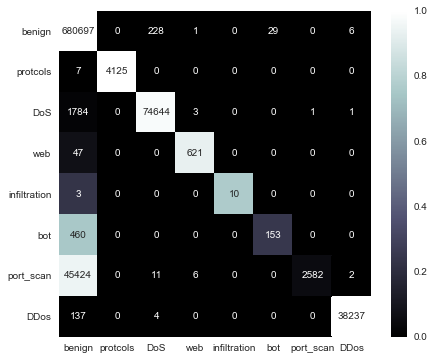

In [12]:
rf = RandomForestClassifier(n_estimators = 50)
train_model(rf, X_train_scaled, y_train)

In [13]:
feature_impotance = pd.DataFrame({'feature': X_train_scaled.columns, 
                                  'importance': rf.feature_importances_}).sort_values(by='importance', ascending=True)
feature_impotance.reset_index()

,index,feature,importance
0,42,Active Std,0.000350
1,45,Idle Std,0.000449
2,24,Fwd PSH Flags,0.000485
3,33,SYN Flag Count,0.000875
4,23,Bwd IAT Min,0.001500
5,43,Active Max,0.001896
6,21,Bwd IAT Std,0.001970
7,32,FIN Flag Count,0.002011
8,20,Bwd IAT Mean,0.002112
9,44,Active Min,0.003103


In [14]:
feature_impotance.tail(10)

,feature,importance
28,Max Packet Length,0.038969
4,Fwd Packet Length Mean,0.039424
29,Packet Length Mean,0.039808
6,Bwd Packet Length Max,0.054694
8,Bwd Packet Length Mean,0.055178
38,Subflow Fwd Bytes,0.056972
0,Destination Port,0.060202
30,Packet Length Std,0.062926
9,Bwd Packet Length Std,0.065724
31,Packet Length Variance,0.073708


In [15]:
feature_impotance.head(12)

,feature,importance
42,Active Std,0.000350
45,Idle Std,0.000449
24,Fwd PSH Flags,0.000485
33,SYN Flag Count,0.000875
23,Bwd IAT Min,0.001500
43,Active Max,0.001896
21,Bwd IAT Std,0.001970
32,FIN Flag Count,0.002011
20,Bwd IAT Mean,0.002112
44,Active Min,0.003103


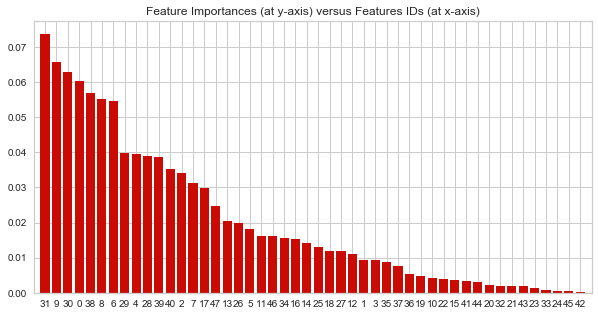

In [16]:
rankings = rf.feature_importances_

listFeatures = np.argsort(rankings)[::-1]
std = np.std([rf.feature_importances_ for tree in rf.estimators_], axis = 0)
plot.figure(figsize = (10, 5))
plot.title("Feature Importances (at y-axis) versus Features IDs (at x-axis)")
plot.bar(range(X_train_scaled.shape[1]), rankings[listFeatures], color = "r", yerr=std[listFeatures], align = "center")
plot.xticks(range(X_train_scaled.shape[1]), listFeatures)
plot.xlim([-1, X_train_scaled.shape[1]])
plot.show()

FEATURES WITH ZERO IMPORTANCE: 

determing what exactly these features are to see if it makes sense to remove them


Active Max - Maximum time a flow was active before becoming idle

Active Min - Minimum time a flow was active before becoming idle

Active Mean - Minimum time a flow was active before becoming idle

Bwd IAT Total - Total time between two packets sent in the backward direction

Bwd IAT Std	- Standard deviation time between two packets sent in the backward direction

Bwd IAT Min - Minimum time between two packets sent in the backward direction

FIN Flag Count - Number of packets with FIN

URG Flag Count - Number of packets with URG

Fwd PSH flag - Number of times the PSH flag was set in packets travelling in the forward direction (0 for UDP)

Active Std - Standard deviation time a flow was active before becoming idle

Idle Std - Standard deviation time a flow was idle before becoming active

In [17]:
df[(df['Fwd PSH Flags'] == 1) & (df['Label'] == 4)].count().head()
# benign: 124762
# FTP-Patator & SSH-Patator: 3961
# DoS: 2735
# web: 0 
# infiltration: 20
# bot: 0
# port_scan: 0
# DDoS: 0

# not getting rid of this feature because it helps detect infiltration attacks

Destination Port          20
Flow Duration             20
Fwd Packet Length Max     20
Fwd Packet Length Min     20
Fwd Packet Length Mean    20
dtype: int64

In [18]:
df[(df['FIN Flag Count'] == 1) & (df['Label'] == 7)].count().head()
# benign: 41188
# FTP-Patator & SSH-Patator: 0
# DoS: 58936
# web: 0 
# infiltration: 0
# bot: 0
# port_scan: 0
# DDoS: 27

# not getting rid of this feature because it helps detect DoS attacks

Destination Port          27
Flow Duration             27
Fwd Packet Length Max     27
Fwd Packet Length Min     27
Fwd Packet Length Mean    27
dtype: int64

### Data

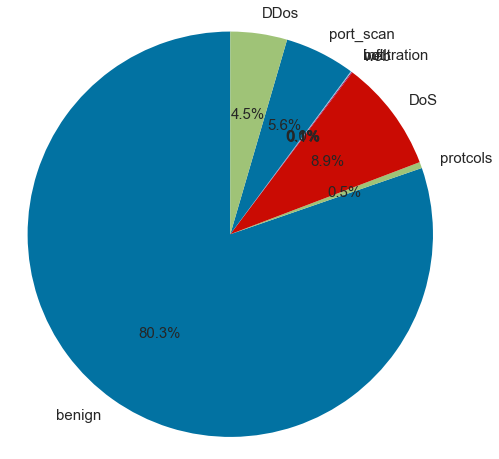

In [19]:
benign = (df['Label']==0).sum()
protcols = (df['Label']==1).sum()
DoS = (df['Label']==2).sum()
web = (df['Label']==3).sum()
infiltration = (df['Label']==4).sum()
bot = (df['Label']==5).sum()
port_scan = (df['Label']==6).sum()
DDos = (df['Label']==7).sum()

labels = 'benign', 'protcols', 'DoS', 'web', 'infiltration', 'bot', 'port_scan', 'DDos',
sizes = [benign, protcols, DoS, web, infiltration, bot, port_scan, DDos]

fig1, ax1 = plot.subplots(figsize=(8,8))
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',shadow=False, startangle=90, textprops={'fontsize': 15})
ax1.axis('equal')

plot.show()

In [20]:
print(sizes)
df.shape

[2273097, 13835, 252672, 2180, 36, 1966, 158930, 128027]


(2830743, 49)

# Training

### Decision Tree


Precent Correct: 80.56%, Error: 0.1944
              precision    recall  f1-score   support

      benign       0.96      1.00      0.98    680961
    protcols       1.00      1.00      1.00      4132
         DoS       0.99      0.96      0.98     76433
         web       0.90      0.87      0.89       668
infiltration       0.00      0.00      0.00        13
         bot       0.42      0.11      0.17       613
   port_scan       1.00      0.51      0.67     48025
        DDos       1.00      0.98      0.99     38378

    accuracy                           0.97    849223
   macro avg       0.78      0.68      0.71    849223
weighted avg       0.97      0.97      0.96    849223




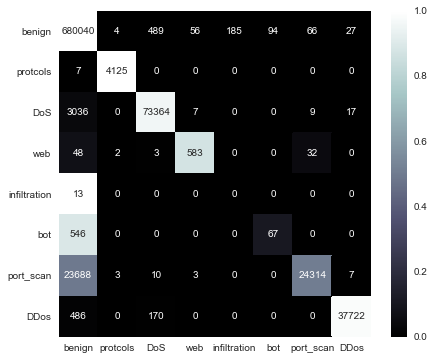

In [21]:
decision_tree = DecisionTreeClassifier()
train_model(decision_tree, X_train_scaled, y_train)

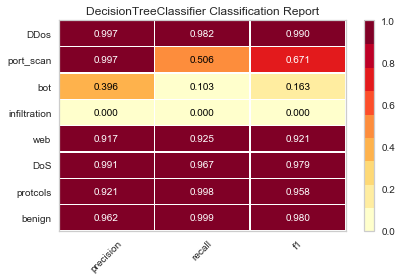

In [22]:
vis_classification_report(decision_tree, X_train_scaled, y_train)

### Decision Tree Balance Sklearn


Precent Correct: 79.46%, Error: 0.2054
              precision    recall  f1-score   support

      benign       0.90      0.99      0.94    680961
    protcols       0.99      0.29      0.45      4132
         DoS       0.98      0.84      0.91     76433
         web       0.96      0.90      0.92       668
infiltration       0.19      1.00      0.33        13
         bot       0.76      0.46      0.58       613
   port_scan       1.00      0.54      0.70     48025
        DDos       0.00      0.00      0.00     38378

    accuracy                           0.90    849223
   macro avg       0.72      0.63      0.60    849223
weighted avg       0.87      0.90      0.88    849223




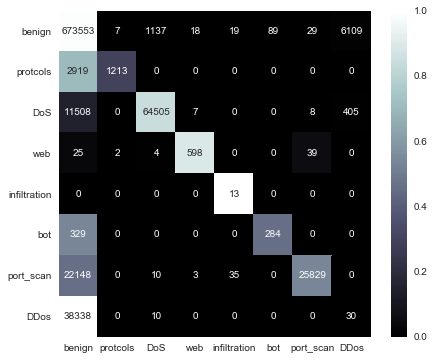

In [23]:
# balancing tree using sklearn 
decision_tree_balanced_sklearn = DecisionTreeClassifier(class_weight='balanced')
train_model(decision_tree_balanced_sklearn, X_train_scaled, y_train)

### Decision Tree Balance Method 2

In [ ]:
decision_tree_balanced_smote = DecisionTreeClassifier()
X_resampled, y_resampled = SMOTE().fit_resample(X_train_scaled, y_train)
train_model(decision_tree_balanced_smote, X_resampled, y_resampled)

### Random Forest


Precent Correct: 80.64%, Error: 0.1936
              precision    recall  f1-score   support

      benign       0.96      1.00      0.98    680961
    protcols       1.00      1.00      1.00      4132
         DoS       1.00      0.98      0.99     76433
         web       0.99      0.92      0.96       668
infiltration       1.00      0.69      0.82        13
         bot       0.93      0.36      0.52       613
   port_scan       1.00      0.50      0.67     48025
        DDos       1.00      1.00      1.00     38378

    accuracy                           0.97    849223
   macro avg       0.98      0.81      0.87    849223
weighted avg       0.97      0.97      0.96    849223




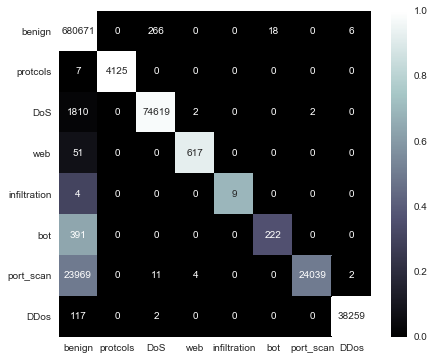

In [25]:
rf = RandomForestClassifier(n_estimators = 50)
train_model(rf, X_train_scaled, y_train)

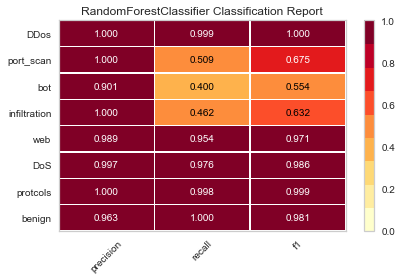

In [26]:
vis_classification_report(rf, X_train_scaled, y_train)

### Random Forest Balanced Sklearn


Precent Correct: 80.49%, Error: 0.1951
              precision    recall  f1-score   support

      benign       0.96      1.00      0.98    680961
    protcols       1.00      1.00      1.00      4132
         DoS       0.98      0.98      0.98     76433
         web       0.98      0.94      0.96       668
infiltration       1.00      0.69      0.82        13
         bot       0.57      0.09      0.16       613
   port_scan       1.00      0.51      0.67     48025
        DDos       1.00      0.98      0.99     38378

    accuracy                           0.97    849223
   macro avg       0.94      0.77      0.82    849223
weighted avg       0.97      0.97      0.96    849223




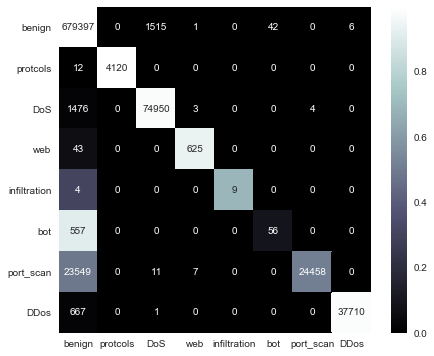

In [27]:
rf_balanced_sklearn = RandomForestClassifier(n_estimators = 50, class_weight='balanced')
train_model(rf_balanced_sklearn, X_train_scaled, y_train)

### Balanced Random Forest 


Precent Correct: 57.81%, Error: 0.4219
              precision    recall  f1-score   support

      benign       1.00      0.71      0.83    680961
    protcols       0.29      1.00      0.45      4132
         DoS       0.58      0.91      0.71     76433
         web       0.02      0.96      0.05       668
infiltration       0.00      0.92      0.00        13
         bot       0.02      1.00      0.03       613
   port_scan       0.81      0.98      0.89     48025
        DDos       0.76      0.97      0.85     38378

    accuracy                           0.76    849223
   macro avg       0.43      0.93      0.48    849223
weighted avg       0.93      0.76      0.82    849223




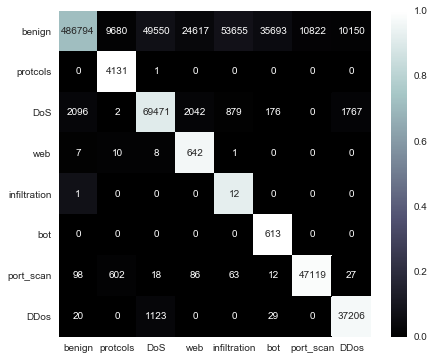

In [30]:
brf = BalancedRandomForestClassifier(n_estimators=50)
train_model(brf, X_train_scaled, y_train)

### Balanced Bagging


Precent Correct: 66.31%, Error: 0.3369
              precision    recall  f1-score   support

      benign       1.00      0.82      0.90    680961
    protcols       0.38      1.00      0.55      4132
         DoS       0.85      0.96      0.90     76433
         web       0.02      0.98      0.04       668
infiltration       0.01      1.00      0.01        13
         bot       0.01      1.00      0.03       613
   port_scan       0.81      0.96      0.88     48025
        DDos       0.68      1.00      0.81     38378

    accuracy                           0.85    849223
   macro avg       0.47      0.97      0.51    849223
weighted avg       0.96      0.85      0.89    849223




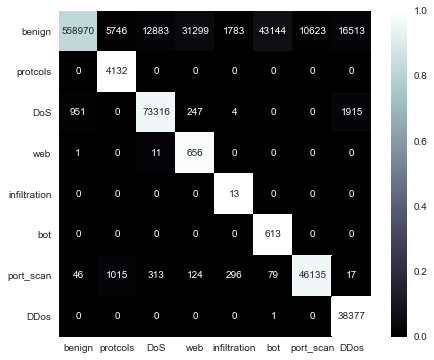

In [31]:
balanced_bagging = BalancedBaggingClassifier(n_estimators=50)
train_model(balanced_bagging, X_train_scaled, y_train)

### XGD Boost

In [32]:
xgd_train = xgb.DMatrix(data = X_train_scaled, label = y_train)
xgd_test = xgb.DMatrix(data = X_valid_scaled)

params = {
    'max_depth': 6,
    'objective': 'multi:softmax',  # error evaluation for multiclass training
    'num_class': 8,
    'n_gpus': 0
}

xgd_tree = xgb.train(params, xgd_train)
pred_xgd = xgd_tree.predict(xgd_test)

print(classification_report(y_valid, pred_xgd, target_names =
                            ['benign', 'protcols', 'DoS', 
                             'web', 'infiltration', 'bot',
                             'port_scan', 'DDos']))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


              precision    recall  f1-score   support

      benign       0.96      1.00      0.98    680961
    protcols       1.00      1.00      1.00      4132
         DoS       0.98      0.96      0.97     76433
         web       0.99      0.87      0.92       668
infiltration       0.13      0.31      0.19        13
         bot       1.00      0.33      0.49       613
   port_scan       1.00      0.46      0.63     48025
        DDos       1.00      0.98      0.99     38378

    accuracy                           0.96    849223
   macro avg       0.88      0.74      0.77    849223
weighted avg       0.96      0.96      0.96    849223



### SGD


Precent Correct: 77.58%, Error: 0.2242


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

      benign       0.94      0.97      0.95    680961
    protcols       0.00      0.00      0.00      4132
         DoS       0.88      0.69      0.77     76433
         web       0.00      0.00      0.00       668
infiltration       0.00      0.00      0.00        13
         bot       0.00      0.00      0.00       613
   port_scan       0.72      0.99      0.83     48025
        DDos       0.97      0.57      0.72     38378

    accuracy                           0.92    849223
   macro avg       0.44      0.40      0.41    849223
weighted avg       0.92      0.92      0.91    849223




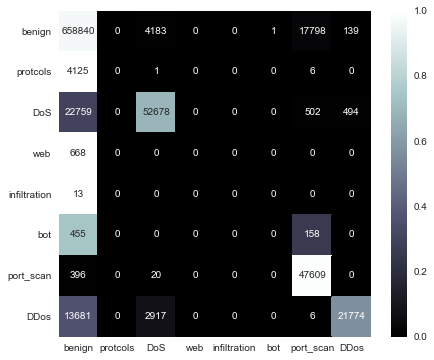

In [33]:
sgd = SGDClassifier(loss='modified_huber', max_iter=50)
train_model(sgd, X_train_scaled, y_train)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


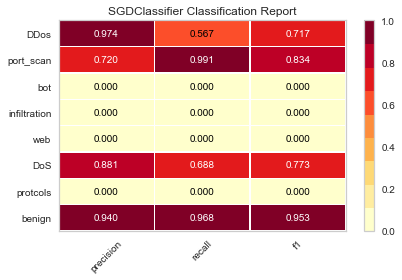

In [34]:
vis_classification_report(sgd, X_train_scaled, y_train)